# Experiment - CNN
We evaluate Adam optimizer on CNN architechture on the CIFAR-10 dataset.


### Optimizers Compared
1. Adam
2. Adam with learnig rate decay
3. SGD with Nesterov momentum
4. Adagrad

### HyperParameters
 - All Optimizers are trained with batchsize of 128.
 - Adam optimizer has The stepsize \\(\alpha\\). 
 - In the paper experiments, they did not mention learning rate decay.
 - We trained models both without decay and with learning rate decay adjusted by \\(\alpha_{t}=\frac{1}{\sqrt{t}}\alpha\\), where t is the epoch number. 

#### Hyper-parameter search
In the paper the hyper-parameters search was done by a dense grid search. We used optuna library for the search. The results are reported using the best hyper-parameter settings both in the paper and in our experiment.

### Weight Initialization
In the paper the models were initialized with the same weights.
In our experiment we did it as well.

### Notes
The paper preprocessed the data with whitening. We tried it, but got better results without it. Thus we focused on normalized data without whitening.

In [16]:
import torch
import torchvision.datasets as dset
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import optuna
import pickle

In [52]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True,
                         download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False,
                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)
num_of_sample = len(trainset)
num_of_test_samples = len(testset)

Files already downloaded and verified
Files already downloaded and verified


In [46]:
input_dim = 32*32*3
epochs = 45

In [5]:
def plot_image(X):
    plt.imshow(X.reshape(32,32,3))
    plt.show()
    plt.close()

### The CNN model
we used same CNN architecture as in the paper that has 3 stages:
- 5x5 convolution filter
- 3x3 max pooling with stride of 2
- fully connected layer of 1000 hidden units (and RELU)

In [22]:
class CNN_(nn.Module):
    def __init__(self):
        super(CNN_, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(6 * 13 * 13, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 6 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [95]:
def score(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            labels = torch.tensor(labels, dtype=torch.long)
            images = torch.tensor(images, dtype=torch.float)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [48]:
def save_model_data(name, model, loss_arr, acc_arr, lr_arr):
    run_number = 0
    PATH = f'./cnn_models/{name}_{run_number}.pkl'
    while os.path.isfile(PATH):
        run_number += 1
        PATH = f'./cnn_models/{name}_{run_number}.pkl'
    torch.save(model.state_dict(), PATH)
    with open(f'cnn_models/{name}_loss.pkl', 'wb') as fp:
        pickle.dump(loss_arr, fp)
    with open(f'cnn_models/{name}_acc.pkl', 'wb') as fp:
        pickle.dump(acc_arr, fp)
    with open(f'cnn_models/{name}_lr.pkl', 'wb') as fp:
        pickle.dump(lr_arr, fp)

### Training Loop

In [32]:
def train(model, trainloader, optimizer, name, learning_rate_decay=False):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_path = f'./cnn_models/{name}_loss.pkl'
    acc_path = f'./cnn_models/{name}_acc.pkl'
    lr_path = f'./cnn_models/{name}_lr.pkl'
    loss_arr = []
    lr_arr = []
    acc_arr = []
    if os.path.isfile(loss_path) and os.path.getsize(loss_path) > 0:
        with open(loss_path, 'rb') as fp:
            loss_arr = pickle.load(fp)
        with open(acc_path, 'rb') as fp:
            acc_arr = pickle.load(fp)
        with open(lr_path, 'rb') as fp:
            lr_arr = pickle.load(fp)
    decay_factor = lambda x: 1/math.sqrt(len(loss_arr)+1) 
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=decay_factor)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            labels = torch.tensor(labels, dtype=torch.long)
            inputs = torch.tensor(inputs, dtype=torch.float)
            optimizer.zero_grad()
            outputs = model(inputs.type(torch.float))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        lr_arr.append(optimizer.param_groups[0]["lr"])
        if learning_rate_decay:
            scheduler.step()
        loss_arr.append(running_loss/num_of_sample)
        acc_arr.append(score(model, testloader))
        print(f'epoch: {epoch}, loss: {running_loss/num_of_sample}, acc: {acc_arr[-1]}')
    save_model_data(name, model, loss_arr, acc_arr, lr_arr)
    return loss_arr, lr_arr

# Parameter Search

In [61]:
def objective_adam(trial):
    model_adam = CNN_()
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    beta_1 = trial.suggest_loguniform("beta_1", 0.6, 1)
    beta_2 = trial.suggest_loguniform("beta_2", 0.9, 1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1)
    optimizer = torch.optim.Adam(model_adam.parameters(), lr=lr, betas=(beta_1, beta_2), weight_decay=weight_decay)
    name = f'adam_lr_{optimizer.param_groups[0]["lr"]}_' + \
    f'beta1_{optimizer.param_groups[0]["betas"][0]}_beta2_{optimizer.param_groups[0]["betas"][1]}_' +\
    f'wd_{optimizer.param_groups[0]["weight_decay"]}'
    loss, lrs = train(model_adam, trainloader, optimizer, name, learning_rate_decay=False)
    return score(model_adam, testloader)

def objective_adam_decay(trial):
    model_adam = CNN_()
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    beta_1 = trial.suggest_loguniform("beta_1", 0.6, 1)
    beta_2 = trial.suggest_loguniform("beta_2", 0.9, 1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1)
    optimizer = torch.optim.Adam(model_adam.parameters(), lr=lr, betas=(beta_1, beta_2), weight_decay=weight_decay)
    name = f'adam_decay_lr_{optimizer.param_groups[0]["lr"]}_' + \
    f'beta1_{optimizer.param_groups[0]["betas"][0]}_beta2_{optimizer.param_groups[0]["betas"][1]}_' +\
    f'wd_{optimizer.param_groups[0]["weight_decay"]}'
    loss, lrs = train(model_adam, trainloader, optimizer, name, learning_rate_decay=True)
    return score(model_adam, testloader)


def objective_adagrad(trial):
    model_adagrad = CNN_()
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1)
    optimizer = torch.optim.Adagrad(model_adagrad.parameters(), lr=lr, weight_decay=weight_decay)
    name = f'adagrad_lr_{optimizer.param_groups[0]["lr"]}_' + \
    f'wd_{optimizer.param_groups[0]["weight_decay"]}'
    loss, lrs = train(model_adagrad, trainloader, optimizer, name, learning_rate_decay=False)
    return score(model_adagrad, testloader)

def objective_sgd_nst(trial):
    model_sgd_nst = CNN_()
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    momentum = trial.suggest_loguniform("momentum", 1e-8, 1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1)
    optimizer = torch.optim.SGD(model_sgd_nst.parameters(), nesterov=True, 
                             momentum=momentum, lr=lr, weight_decay=weight_decay)
    name = f'sgd_nst_lr_{optimizer.param_groups[0]["lr"]}_' + \
    f'momentum_{optimizer.param_groups[0]["momentum"]}' +\
    f'wd_{optimizer.param_groups[0]["weight_decay"]}'
    loss, lrs = train(model_sgd_nst, trainloader, optimizer, name, learning_rate_decay=False)
    return score(model_sgd_nst, testloader)

In [53]:
study_adam = optuna.create_study(direction='maximize')
study_adam.optimize(objective_adam, n_trials=10)
best_adam=study_adam.best_trial
print(best_adam.value)

[I 2021-04-01 20:48:48,124] A new study created in memory with name: no-name-c74b19d2-339c-4337-866c-6f0014eb4426
<ipython-input-32-4f502ced3763>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-32-4f502ced3763>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-8-6b7ae6259317>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-8-6b7ae6259317>:8: UserWar

Accuracy of the network on the 10000 test images: 36 %
epoch: 0, loss: 0.015854277818202974, acc: 36.54
Accuracy of the network on the 10000 test images: 40 %
epoch: 1, loss: 0.013848531606197357, acc: 40.54
Accuracy of the network on the 10000 test images: 43 %
epoch: 2, loss: 0.012998283615112304, acc: 43.06
Accuracy of the network on the 10000 test images: 44 %
epoch: 3, loss: 0.01246403531551361, acc: 44.84
Accuracy of the network on the 10000 test images: 45 %
epoch: 4, loss: 0.012055952975749969, acc: 45.82
Accuracy of the network on the 10000 test images: 47 %
epoch: 5, loss: 0.011723682770729065, acc: 47.41
Accuracy of the network on the 10000 test images: 48 %
epoch: 6, loss: 0.011458088910579681, acc: 48.33
Accuracy of the network on the 10000 test images: 49 %
epoch: 7, loss: 0.011235599346160889, acc: 49.34
Accuracy of the network on the 10000 test images: 50 %
epoch: 8, loss: 0.011043769638538361, acc: 50.17
Accuracy of the network on the 10000 test images: 50 %
epoch: 9, 

[I 2021-04-01 21:25:02,747] Trial 0 finished with value: 58.87 and parameters: {'lr': 3.0329567663730086e-05, 'beta_1': 0.6257359366091633, 'beta_2': 0.910830589301355, 'weight_decay': 0.000741436357125832}. Best is trial 0 with value: 58.87.


Accuracy of the network on the 10000 test images: 58 %
Accuracy of the network on the 10000 test images: 29 %
epoch: 0, loss: 0.016079808840751646, acc: 29.2
Accuracy of the network on the 10000 test images: 32 %
epoch: 1, loss: 0.014897664992809296, acc: 32.28
Accuracy of the network on the 10000 test images: 34 %
epoch: 2, loss: 0.014593023915290833, acc: 34.14
Accuracy of the network on the 10000 test images: 35 %
epoch: 3, loss: 0.014388652951717377, acc: 35.01
Accuracy of the network on the 10000 test images: 35 %
epoch: 4, loss: 0.014269519846439361, acc: 35.18
Accuracy of the network on the 10000 test images: 35 %
epoch: 5, loss: 0.014169243891239166, acc: 35.18
Accuracy of the network on the 10000 test images: 36 %
epoch: 6, loss: 0.014051144099235535, acc: 36.56
Accuracy of the network on the 10000 test images: 36 %
epoch: 7, loss: 0.013909910454750062, acc: 36.83
Accuracy of the network on the 10000 test images: 38 %
epoch: 8, loss: 0.013734450716972352, acc: 38.09
Accuracy o

[I 2021-04-01 22:08:10,233] Trial 1 finished with value: 39.99 and parameters: {'lr': 0.0002459549294746681, 'beta_1': 0.7368789945102427, 'beta_2': 0.9342044232472739, 'weight_decay': 0.1126090591775746}. Best is trial 0 with value: 58.87.


Accuracy of the network on the 10000 test images: 39 %
Accuracy of the network on the 10000 test images: 33 %
epoch: 0, loss: 0.01600030180454254, acc: 33.6
Accuracy of the network on the 10000 test images: 36 %
epoch: 1, loss: 0.014526723210811615, acc: 36.92
Accuracy of the network on the 10000 test images: 39 %
epoch: 2, loss: 0.013867350964546204, acc: 39.82
Accuracy of the network on the 10000 test images: 41 %
epoch: 3, loss: 0.013338676841259002, acc: 41.62
Accuracy of the network on the 10000 test images: 43 %
epoch: 4, loss: 0.012889378380775451, acc: 43.18
Accuracy of the network on the 10000 test images: 44 %
epoch: 5, loss: 0.01251499073266983, acc: 44.44
Accuracy of the network on the 10000 test images: 45 %
epoch: 6, loss: 0.012198725380897522, acc: 45.25
Accuracy of the network on the 10000 test images: 45 %
epoch: 7, loss: 0.011937632739543914, acc: 45.93
Accuracy of the network on the 10000 test images: 47 %
epoch: 8, loss: 0.011719186205863952, acc: 47.08
Accuracy of 

[I 2021-04-01 22:47:58,394] Trial 2 finished with value: 57.26 and parameters: {'lr': 2.4104466531683177e-05, 'beta_1': 0.8320700587953377, 'beta_2': 0.983162177926483, 'weight_decay': 0.0014247561961216687}. Best is trial 0 with value: 58.87.


Accuracy of the network on the 10000 test images: 57 %
Accuracy of the network on the 10000 test images: 34 %
epoch: 0, loss: 0.01583314785718918, acc: 34.24
Accuracy of the network on the 10000 test images: 36 %
epoch: 1, loss: 0.014302793736457825, acc: 36.91
Accuracy of the network on the 10000 test images: 37 %
epoch: 2, loss: 0.013760518560409546, acc: 37.4
Accuracy of the network on the 10000 test images: 38 %
epoch: 3, loss: 0.013476762235164643, acc: 38.23
Accuracy of the network on the 10000 test images: 40 %
epoch: 4, loss: 0.013313442807197571, acc: 40.72
Accuracy of the network on the 10000 test images: 39 %
epoch: 5, loss: 0.01321802419424057, acc: 39.55
Accuracy of the network on the 10000 test images: 39 %
epoch: 6, loss: 0.013143156533241272, acc: 39.78
Accuracy of the network on the 10000 test images: 40 %
epoch: 7, loss: 0.013081134040355682, acc: 40.31
Accuracy of the network on the 10000 test images: 40 %
epoch: 8, loss: 0.013028694312572479, acc: 40.94
Accuracy of 

[I 2021-04-01 23:18:07,097] Trial 3 finished with value: 42.49 and parameters: {'lr': 0.00012347818812748332, 'beta_1': 0.605378251408948, 'beta_2': 0.9081881888083553, 'weight_decay': 0.0864944690570275}. Best is trial 0 with value: 58.87.


Accuracy of the network on the 10000 test images: 42 %
Accuracy of the network on the 10000 test images: 28 %
epoch: 0, loss: 0.017089623856544493, acc: 28.27
Accuracy of the network on the 10000 test images: 32 %
epoch: 1, loss: 0.015615274560451508, acc: 32.58
Accuracy of the network on the 10000 test images: 34 %
epoch: 2, loss: 0.014846383588314057, acc: 34.54
Accuracy of the network on the 10000 test images: 36 %
epoch: 3, loss: 0.014390345392227173, acc: 36.19
Accuracy of the network on the 10000 test images: 37 %
epoch: 4, loss: 0.014046355311870574, acc: 37.68
Accuracy of the network on the 10000 test images: 38 %
epoch: 5, loss: 0.013751323444843292, acc: 38.76
Accuracy of the network on the 10000 test images: 39 %
epoch: 6, loss: 0.013495308918952943, acc: 39.8
Accuracy of the network on the 10000 test images: 40 %
epoch: 7, loss: 0.013264861624240875, acc: 40.54
Accuracy of the network on the 10000 test images: 41 %
epoch: 8, loss: 0.013048344943523407, acc: 41.31
Accuracy o

[I 2021-04-01 23:47:56,940] Trial 4 finished with value: 53.39 and parameters: {'lr': 1.0665986225397367e-05, 'beta_1': 0.7187724549353905, 'beta_2': 0.9455244562043873, 'weight_decay': 0.00011370525770529982}. Best is trial 0 with value: 58.87.


Accuracy of the network on the 10000 test images: 53 %
Accuracy of the network on the 10000 test images: 50 %
epoch: 0, loss: 0.012279182062149048, acc: 50.12
Accuracy of the network on the 10000 test images: 56 %
epoch: 1, loss: 0.010200656740665436, acc: 56.07
Accuracy of the network on the 10000 test images: 56 %
epoch: 2, loss: 0.009276502248048782, acc: 56.66
Accuracy of the network on the 10000 test images: 60 %
epoch: 3, loss: 0.008613731999397278, acc: 60.77
Accuracy of the network on the 10000 test images: 59 %
epoch: 4, loss: 0.008092371366024018, acc: 59.4
Accuracy of the network on the 10000 test images: 62 %
epoch: 5, loss: 0.007602322781085968, acc: 62.41
Accuracy of the network on the 10000 test images: 61 %
epoch: 6, loss: 0.007142476638555527, acc: 61.82
Accuracy of the network on the 10000 test images: 64 %
epoch: 7, loss: 0.0067684707140922545, acc: 64.09
Accuracy of the network on the 10000 test images: 65 %
epoch: 8, loss: 0.006398357236385346, acc: 65.11
Accuracy 

[I 2021-04-02 00:17:43,807] Trial 5 finished with value: 63.5 and parameters: {'lr': 0.0009447978407001864, 'beta_1': 0.7625060255871918, 'beta_2': 0.9880374454526498, 'weight_decay': 0.0008026372072621661}. Best is trial 5 with value: 63.5.


Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 46 %
epoch: 0, loss: 0.012663276536464691, acc: 46.84
Accuracy of the network on the 10000 test images: 51 %
epoch: 1, loss: 0.01128121166229248, acc: 51.77
Accuracy of the network on the 10000 test images: 50 %
epoch: 2, loss: 0.010816261947155, acc: 50.95
Accuracy of the network on the 10000 test images: 51 %
epoch: 3, loss: 0.010535737404823303, acc: 51.06
Accuracy of the network on the 10000 test images: 53 %
epoch: 4, loss: 0.010318426311016083, acc: 53.1
Accuracy of the network on the 10000 test images: 54 %
epoch: 5, loss: 0.010132970616817474, acc: 54.22
Accuracy of the network on the 10000 test images: 52 %
epoch: 6, loss: 0.010015424633026123, acc: 52.74
Accuracy of the network on the 10000 test images: 53 %
epoch: 7, loss: 0.009920499248504638, acc: 53.33
Accuracy of the network on the 10000 test images: 55 %
epoch: 8, loss: 0.009841426537036896, acc: 55.89
Accuracy of th

[I 2021-04-02 00:46:56,366] Trial 6 finished with value: 58.07 and parameters: {'lr': 0.0030133670761357378, 'beta_1': 0.8146671173603899, 'beta_2': 0.9652361789129354, 'weight_decay': 0.008657495026415923}. Best is trial 5 with value: 63.5.


Accuracy of the network on the 10000 test images: 58 %
Accuracy of the network on the 10000 test images: 49 %
epoch: 0, loss: 0.012440616478919983, acc: 49.57
Accuracy of the network on the 10000 test images: 55 %
epoch: 1, loss: 0.010436574105024337, acc: 55.05
Accuracy of the network on the 10000 test images: 58 %
epoch: 2, loss: 0.009747388098239898, acc: 58.07
Accuracy of the network on the 10000 test images: 59 %
epoch: 3, loss: 0.009223342655897141, acc: 59.28
Accuracy of the network on the 10000 test images: 58 %
epoch: 4, loss: 0.008872745395898819, acc: 58.17
Accuracy of the network on the 10000 test images: 58 %
epoch: 5, loss: 0.008556748509407044, acc: 58.81
Accuracy of the network on the 10000 test images: 59 %
epoch: 6, loss: 0.008410779266357422, acc: 59.96
Accuracy of the network on the 10000 test images: 61 %
epoch: 7, loss: 0.008210432447195054, acc: 61.24
Accuracy of the network on the 10000 test images: 59 %
epoch: 8, loss: 0.008081990270614623, acc: 59.13
Accuracy 

[I 2021-04-02 01:37:56,771] Trial 7 finished with value: 61.25 and parameters: {'lr': 0.007085475570332389, 'beta_1': 0.7149200452196834, 'beta_2': 0.9916012479132239, 'weight_decay': 0.00019715771982581874}. Best is trial 5 with value: 63.5.


Accuracy of the network on the 10000 test images: 61 %
Accuracy of the network on the 10000 test images: 33 %
epoch: 0, loss: 0.016109921185970308, acc: 33.56
Accuracy of the network on the 10000 test images: 36 %
epoch: 1, loss: 0.014536633639335632, acc: 36.09
Accuracy of the network on the 10000 test images: 38 %
epoch: 2, loss: 0.013882614994049072, acc: 38.16
Accuracy of the network on the 10000 test images: 40 %
epoch: 3, loss: 0.013457889833450318, acc: 40.34
Accuracy of the network on the 10000 test images: 40 %
epoch: 4, loss: 0.013181047978401184, acc: 40.45
Accuracy of the network on the 10000 test images: 40 %
epoch: 5, loss: 0.012990613510608673, acc: 40.8
Accuracy of the network on the 10000 test images: 41 %
epoch: 6, loss: 0.012845653412342072, acc: 41.14
Accuracy of the network on the 10000 test images: 41 %
epoch: 7, loss: 0.012746891148090363, acc: 41.85
Accuracy of the network on the 10000 test images: 41 %
epoch: 8, loss: 0.012662218294143678, acc: 41.89
Accuracy o

[I 2021-04-02 02:06:47,054] Trial 8 finished with value: 46.27 and parameters: {'lr': 7.090494348202945e-05, 'beta_1': 0.6840330367899946, 'beta_2': 0.9135541070078529, 'weight_decay': 0.06579945083375856}. Best is trial 5 with value: 63.5.


Accuracy of the network on the 10000 test images: 46 %
Accuracy of the network on the 10000 test images: 10 %
epoch: 0, loss: 0.018690339040756225, acc: 10.24
Accuracy of the network on the 10000 test images: 10 %
epoch: 1, loss: 0.018239706110954285, acc: 10.51
Accuracy of the network on the 10000 test images: 10 %
epoch: 2, loss: 0.019775685057640074, acc: 10.02
Accuracy of the network on the 10000 test images: 15 %
epoch: 3, loss: 0.01903887508869171, acc: 15.74
Accuracy of the network on the 10000 test images: 15 %
epoch: 4, loss: 0.019428885054588316, acc: 15.84
Accuracy of the network on the 10000 test images: 15 %
epoch: 5, loss: 0.017932018995285036, acc: 15.5
Accuracy of the network on the 10000 test images: 16 %
epoch: 6, loss: 0.018865900330543518, acc: 16.11
Accuracy of the network on the 10000 test images: 10 %
epoch: 7, loss: 0.018786439304351806, acc: 10.0
Accuracy of the network on the 10000 test images: 16 %
epoch: 8, loss: 0.019150532875061035, acc: 16.55
Accuracy of 

[I 2021-04-02 02:34:45,463] Trial 9 finished with value: 9.97 and parameters: {'lr': 0.014817510802557018, 'beta_1': 0.6302885064793113, 'beta_2': 0.9596699746154189, 'weight_decay': 0.07807290022182851}. Best is trial 5 with value: 63.5.


Accuracy of the network on the 10000 test images: 9 %
63.5


In [64]:
study_adam_decay = optuna.create_study(direction='maximize')
study_adam_decay.optimize(objective_adam_decay, n_trials=10)
best_adam_decay=study_adam_decay.best_trial
print(best_adam_decay.value)

[I 2021-04-02 09:27:11,494] A new study created in memory with name: no-name-8dd7cb92-e94f-44bc-b9a9-a21fcccdc5a5
<ipython-input-32-4f502ced3763>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-32-4f502ced3763>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-8-6b7ae6259317>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-8-6b7ae6259317>:8: UserWar

Accuracy of the network on the 10000 test images: 42 %
epoch: 0, loss: 0.013071010653972625, acc: 42.45
Accuracy of the network on the 10000 test images: 45 %
epoch: 1, loss: 0.011751722173690795, acc: 45.96
Accuracy of the network on the 10000 test images: 47 %
epoch: 2, loss: 0.011122441930770874, acc: 47.1
Accuracy of the network on the 10000 test images: 50 %
epoch: 3, loss: 0.010728246865272522, acc: 50.32
Accuracy of the network on the 10000 test images: 50 %
epoch: 4, loss: 0.010478133912086487, acc: 50.37
Accuracy of the network on the 10000 test images: 53 %
epoch: 5, loss: 0.010281742317676545, acc: 53.56
Accuracy of the network on the 10000 test images: 53 %
epoch: 6, loss: 0.01011384030342102, acc: 53.33
Accuracy of the network on the 10000 test images: 55 %
epoch: 7, loss: 0.009982297701835632, acc: 55.35
Accuracy of the network on the 10000 test images: 55 %
epoch: 8, loss: 0.009853692543506622, acc: 55.3
Accuracy of the network on the 10000 test images: 54 %
epoch: 9, lo

[I 2021-04-02 10:02:47,592] Trial 0 finished with value: 59.88 and parameters: {'lr': 0.0033340585322304546, 'beta_1': 0.6469256174657949, 'beta_2': 0.9184092524270937, 'weight_decay': 0.011677984118048847}. Best is trial 0 with value: 59.88.


Accuracy of the network on the 10000 test images: 59 %
Accuracy of the network on the 10000 test images: 55 %
epoch: 0, loss: 0.011688362321853638, acc: 55.68
Accuracy of the network on the 10000 test images: 56 %
epoch: 1, loss: 0.009598472125530243, acc: 56.99
Accuracy of the network on the 10000 test images: 60 %
epoch: 2, loss: 0.008286466941833496, acc: 60.38
Accuracy of the network on the 10000 test images: 62 %
epoch: 3, loss: 0.007398256332874298, acc: 62.45
Accuracy of the network on the 10000 test images: 63 %
epoch: 4, loss: 0.00671369772195816, acc: 63.67
Accuracy of the network on the 10000 test images: 64 %
epoch: 5, loss: 0.006105767483711243, acc: 64.96
Accuracy of the network on the 10000 test images: 64 %
epoch: 6, loss: 0.005604583684206009, acc: 64.34
Accuracy of the network on the 10000 test images: 64 %
epoch: 7, loss: 0.005136972315907478, acc: 64.2
Accuracy of the network on the 10000 test images: 64 %
epoch: 8, loss: 0.0047088476610183715, acc: 64.68
Accuracy o

[I 2021-04-02 10:38:10,533] Trial 1 finished with value: 62.53 and parameters: {'lr': 0.003775074489697125, 'beta_1': 0.8258792490267167, 'beta_2': 0.9182567624213522, 'weight_decay': 0.0001858010671201774}. Best is trial 1 with value: 62.53.


Accuracy of the network on the 10000 test images: 62 %
Accuracy of the network on the 10000 test images: 47 %
epoch: 0, loss: 0.013111785566806793, acc: 47.31
Accuracy of the network on the 10000 test images: 53 %
epoch: 1, loss: 0.010916226284503937, acc: 53.01
Accuracy of the network on the 10000 test images: 54 %
epoch: 2, loss: 0.009987780210971832, acc: 54.28
Accuracy of the network on the 10000 test images: 56 %
epoch: 3, loss: 0.009448675447702408, acc: 56.71
Accuracy of the network on the 10000 test images: 57 %
epoch: 4, loss: 0.009055076010227203, acc: 57.41
Accuracy of the network on the 10000 test images: 57 %
epoch: 5, loss: 0.008735673842430115, acc: 57.82
Accuracy of the network on the 10000 test images: 59 %
epoch: 6, loss: 0.008439024510383607, acc: 59.0
Accuracy of the network on the 10000 test images: 59 %
epoch: 7, loss: 0.008163146513700485, acc: 59.86
Accuracy of the network on the 10000 test images: 59 %
epoch: 8, loss: 0.00794388416647911, acc: 59.49
Accuracy of

[I 2021-04-02 11:16:19,314] Trial 2 finished with value: 63.64 and parameters: {'lr': 0.0003212117961292483, 'beta_1': 0.9722061696795171, 'beta_2': 0.9114504786858723, 'weight_decay': 2.781831515602368e-05}. Best is trial 2 with value: 63.64.


Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 37 %
epoch: 0, loss: 0.014601226115226745, acc: 37.76
Accuracy of the network on the 10000 test images: 37 %
epoch: 1, loss: 0.013465392842292786, acc: 37.22
Accuracy of the network on the 10000 test images: 40 %
epoch: 2, loss: 0.013187117049694061, acc: 40.73
Accuracy of the network on the 10000 test images: 40 %
epoch: 3, loss: 0.013033803355693816, acc: 40.04
Accuracy of the network on the 10000 test images: 41 %
epoch: 4, loss: 0.012943034358024597, acc: 41.17
Accuracy of the network on the 10000 test images: 41 %
epoch: 5, loss: 0.012913626191616059, acc: 41.99
Accuracy of the network on the 10000 test images: 41 %
epoch: 6, loss: 0.012864799196720123, acc: 41.98
Accuracy of the network on the 10000 test images: 42 %
epoch: 7, loss: 0.012837598981857299, acc: 42.14
Accuracy of the network on the 10000 test images: 42 %
epoch: 8, loss: 0.012800283470153809, acc: 42.85
Accuracy 

[I 2021-04-02 11:50:53,612] Trial 3 finished with value: 43.53 and parameters: {'lr': 0.00169842929621875, 'beta_1': 0.912363904853316, 'beta_2': 0.9462485583703574, 'weight_decay': 0.08460561333701704}. Best is trial 2 with value: 63.64.


Accuracy of the network on the 10000 test images: 43 %
Accuracy of the network on the 10000 test images: 27 %
epoch: 0, loss: 0.021885843091011048, acc: 27.04
Accuracy of the network on the 10000 test images: 23 %
epoch: 1, loss: 0.01797928120136261, acc: 23.85
Accuracy of the network on the 10000 test images: 22 %
epoch: 2, loss: 0.015711790218353273, acc: 22.22
Accuracy of the network on the 10000 test images: 33 %
epoch: 3, loss: 0.014865685815811156, acc: 33.36
Accuracy of the network on the 10000 test images: 28 %
epoch: 4, loss: 0.014211520202159881, acc: 28.29
Accuracy of the network on the 10000 test images: 39 %
epoch: 5, loss: 0.013137942261695863, acc: 39.58
Accuracy of the network on the 10000 test images: 41 %
epoch: 6, loss: 0.012344432215690614, acc: 41.83
Accuracy of the network on the 10000 test images: 47 %
epoch: 7, loss: 0.011667673346996307, acc: 47.18
Accuracy of the network on the 10000 test images: 50 %
epoch: 8, loss: 0.011062769222259522, acc: 50.55
Accuracy o

[I 2021-04-02 12:24:38,779] Trial 4 finished with value: 54.32 and parameters: {'lr': 0.030689107877646084, 'beta_1': 0.7482819481755971, 'beta_2': 0.9328485869878572, 'weight_decay': 8.166740350403321e-05}. Best is trial 2 with value: 63.64.


Accuracy of the network on the 10000 test images: 54 %
Accuracy of the network on the 10000 test images: 14 %
epoch: 0, loss: 0.01796468389034271, acc: 14.6
Accuracy of the network on the 10000 test images: 16 %
epoch: 1, loss: 0.017947194457054137, acc: 16.33
Accuracy of the network on the 10000 test images: 17 %
epoch: 2, loss: 0.017981586294174193, acc: 17.09
Accuracy of the network on the 10000 test images: 10 %
epoch: 3, loss: 0.01800123423576355, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 4, loss: 0.018006210713386536, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 5, loss: 0.018006530151367186, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 6, loss: 0.018006494450569153, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 7, loss: 0.01800645875453949, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 8, loss: 0.01800641544342041, acc: 10.0
Accuracy of the netw

[I 2021-04-02 12:48:34,094] Trial 5 finished with value: 10.0 and parameters: {'lr': 2.2729379157170638e-05, 'beta_1': 0.613101799904273, 'beta_2': 0.978420226884878, 'weight_decay': 0.48593355511907704}. Best is trial 2 with value: 63.64.


Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 10 %
epoch: 0, loss: 0.01800557547092438, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 1, loss: 0.01800682499885559, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 2, loss: 0.018006898913383484, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 3, loss: 0.018006533966064452, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 4, loss: 0.018006776394844055, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 5, loss: 0.018006780424118043, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 6, loss: 0.018006652717590332, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 7, loss: 0.01800640374660492, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 8, loss: 0.018006634187698364, acc: 10.0
Accuracy of the netwo

[I 2021-04-02 13:24:00,043] Trial 6 finished with value: 10.0 and parameters: {'lr': 0.0045638978914709335, 'beta_1': 0.614557238291447, 'beta_2': 0.9986456768764302, 'weight_decay': 0.5179200276292126}. Best is trial 2 with value: 63.64.


Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 50 %
epoch: 0, loss: 0.012323199129104614, acc: 50.39
Accuracy of the network on the 10000 test images: 53 %
epoch: 1, loss: 0.010585856981277467, acc: 53.58
Accuracy of the network on the 10000 test images: 57 %
epoch: 2, loss: 0.009696770503520965, acc: 57.14
Accuracy of the network on the 10000 test images: 59 %
epoch: 3, loss: 0.00908704690694809, acc: 59.64
Accuracy of the network on the 10000 test images: 60 %
epoch: 4, loss: 0.008599505643844605, acc: 60.7
Accuracy of the network on the 10000 test images: 59 %
epoch: 5, loss: 0.008219002892971039, acc: 59.81
Accuracy of the network on the 10000 test images: 62 %
epoch: 6, loss: 0.00789624776005745, acc: 62.61
Accuracy of the network on the 10000 test images: 63 %
epoch: 7, loss: 0.007590454313755036, acc: 63.43
Accuracy of the network on the 10000 test images: 63 %
epoch: 8, loss: 0.007298831669092178, acc: 63.24
Accuracy of 

[I 2021-04-02 13:56:05,536] Trial 7 finished with value: 65.28 and parameters: {'lr': 0.0009626412380587923, 'beta_1': 0.9649142191496952, 'beta_2': 0.9122508454250179, 'weight_decay': 0.0022247666238587355}. Best is trial 7 with value: 65.28.


Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 10 %
epoch: 0, loss: 0.017984432768821716, acc: 10.02
Accuracy of the network on the 10000 test images: 11 %
epoch: 1, loss: 0.01796532904148102, acc: 11.58
Accuracy of the network on the 10000 test images: 10 %
epoch: 2, loss: 0.017947980666160584, acc: 10.64
Accuracy of the network on the 10000 test images: 10 %
epoch: 3, loss: 0.01791836522102356, acc: 10.0
Accuracy of the network on the 10000 test images: 13 %
epoch: 4, loss: 0.017923342370986937, acc: 13.75
Accuracy of the network on the 10000 test images: 12 %
epoch: 5, loss: 0.017924189772605896, acc: 12.03
Accuracy of the network on the 10000 test images: 10 %
epoch: 6, loss: 0.017922314257621766, acc: 10.0
Accuracy of the network on the 10000 test images: 15 %
epoch: 7, loss: 0.017889181728363037, acc: 15.74
Accuracy of the network on the 10000 test images: 13 %
epoch: 8, loss: 0.017920869603157044, acc: 13.53
Accuracy of t

[I 2021-04-02 14:30:06,036] Trial 8 finished with value: 9.77 and parameters: {'lr': 0.0027846440461680947, 'beta_1': 0.9940697515225473, 'beta_2': 0.909462800319965, 'weight_decay': 0.5259202452226047}. Best is trial 7 with value: 65.28.


Accuracy of the network on the 10000 test images: 9 %
Accuracy of the network on the 10000 test images: 51 %
epoch: 0, loss: 0.011875656962394714, acc: 51.41
Accuracy of the network on the 10000 test images: 55 %
epoch: 1, loss: 0.009846098557710648, acc: 55.73
Accuracy of the network on the 10000 test images: 60 %
epoch: 2, loss: 0.008688405925035477, acc: 60.11
Accuracy of the network on the 10000 test images: 61 %
epoch: 3, loss: 0.007901193157434464, acc: 61.48
Accuracy of the network on the 10000 test images: 62 %
epoch: 4, loss: 0.007259350806474686, acc: 62.15
Accuracy of the network on the 10000 test images: 62 %
epoch: 5, loss: 0.006697283943891525, acc: 62.77
Accuracy of the network on the 10000 test images: 63 %
epoch: 6, loss: 0.0062040456426143645, acc: 63.56
Accuracy of the network on the 10000 test images: 63 %
epoch: 7, loss: 0.005741967407464981, acc: 63.57
Accuracy of the network on the 10000 test images: 64 %
epoch: 8, loss: 0.0052880478620529175, acc: 64.2
Accuracy 

[I 2021-04-02 15:44:48,141] Trial 9 finished with value: 63.3 and parameters: {'lr': 0.001028930255472953, 'beta_1': 0.6421638769024658, 'beta_2': 0.999322783339903, 'weight_decay': 0.00013798428498595748}. Best is trial 7 with value: 65.28.


Accuracy of the network on the 10000 test images: 63 %
65.28


In [36]:
study_adagrad = optuna.create_study(direction='maximize')
study_adagrad.optimize(objective_adagrad, n_trials=10)
best_adagrad=study_adagrad.best_trial
print(best_adagrad.value)

[I 2021-04-01 17:29:12,527] A new study created in memory with name: no-name-733f6cb3-eacf-4c5a-8997-c977e16f8940
<ipython-input-32-4f502ced3763>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-32-4f502ced3763>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-8-6b7ae6259317>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-8-6b7ae6259317>:8: UserWar

Accuracy of the network on the 10000 test images: 28 %
epoch: 0, loss: 0.0168011989235878, acc: 28.18
Accuracy of the network on the 10000 test images: 30 %
epoch: 1, loss: 0.015939300799369813, acc: 30.52
Accuracy of the network on the 10000 test images: 32 %
epoch: 2, loss: 0.015516585528850555, acc: 32.52
Accuracy of the network on the 10000 test images: 33 %
epoch: 3, loss: 0.015229756563901901, acc: 33.6
Accuracy of the network on the 10000 test images: 34 %
epoch: 4, loss: 0.015002314418554307, acc: 34.42
Accuracy of the network on the 10000 test images: 35 %
epoch: 5, loss: 0.014818913638591766, acc: 35.64
Accuracy of the network on the 10000 test images: 35 %
epoch: 6, loss: 0.014658591777086259, acc: 35.78
Accuracy of the network on the 10000 test images: 36 %
epoch: 7, loss: 0.014526981765031815, acc: 36.28
Accuracy of the network on the 10000 test images: 36 %
epoch: 8, loss: 0.014408999329805374, acc: 36.64
Accuracy of the network on the 10000 test images: 37 %
epoch: 9, lo

[I 2021-04-01 17:32:13,097] Trial 0 finished with value: 38.86 and parameters: {'lr': 0.00020947210068908456, 'weight_decay': 0.02306932446640321}. Best is trial 0 with value: 38.86.


Accuracy of the network on the 10000 test images: 38 %
Accuracy of the network on the 10000 test images: 33 %
epoch: 0, loss: 0.01574980492591858, acc: 33.38
Accuracy of the network on the 10000 test images: 36 %
epoch: 1, loss: 0.014618078112602234, acc: 36.36
Accuracy of the network on the 10000 test images: 37 %
epoch: 2, loss: 0.014205123537778854, acc: 37.1
Accuracy of the network on the 10000 test images: 38 %
epoch: 3, loss: 0.013944700717926025, acc: 38.48
Accuracy of the network on the 10000 test images: 39 %
epoch: 4, loss: 0.013735537719726562, acc: 39.14
Accuracy of the network on the 10000 test images: 40 %
epoch: 5, loss: 0.013594005000591278, acc: 40.06
Accuracy of the network on the 10000 test images: 40 %
epoch: 6, loss: 0.013443922173976898, acc: 40.3
Accuracy of the network on the 10000 test images: 40 %
epoch: 7, loss: 0.013314916235208512, acc: 40.96
Accuracy of the network on the 10000 test images: 41 %
epoch: 8, loss: 0.013231585782766342, acc: 41.08
Accuracy of 

[I 2021-04-01 17:35:20,806] Trial 1 finished with value: 42.64 and parameters: {'lr': 0.0004532799648512576, 'weight_decay': 1.90096708452102e-05}. Best is trial 1 with value: 42.64.


Accuracy of the network on the 10000 test images: 42 %
Accuracy of the network on the 10000 test images: 30 %
epoch: 0, loss: 0.01563145658969879, acc: 30.5
Accuracy of the network on the 10000 test images: 27 %
epoch: 1, loss: 0.014378880703449249, acc: 27.94
Accuracy of the network on the 10000 test images: 33 %
epoch: 2, loss: 0.013853951382637024, acc: 33.1
Accuracy of the network on the 10000 test images: 36 %
epoch: 3, loss: 0.01351414977312088, acc: 36.32
Accuracy of the network on the 10000 test images: 39 %
epoch: 4, loss: 0.013309525322914123, acc: 39.0
Accuracy of the network on the 10000 test images: 33 %
epoch: 5, loss: 0.013172445023059845, acc: 33.5
Accuracy of the network on the 10000 test images: 38 %
epoch: 6, loss: 0.013065474271774293, acc: 38.4
Accuracy of the network on the 10000 test images: 41 %
epoch: 7, loss: 0.012928840667009354, acc: 41.26
Accuracy of the network on the 10000 test images: 39 %
epoch: 8, loss: 0.012870719450712205, acc: 39.66
Accuracy of the 

[I 2021-04-01 17:51:37,876] Trial 2 finished with value: 40.06 and parameters: {'lr': 0.006458598325575179, 'weight_decay': 0.05951056589835504}. Best is trial 1 with value: 42.64.


Accuracy of the network on the 10000 test images: 40 %
Accuracy of the network on the 10000 test images: 9 %
epoch: 0, loss: 0.01808010092973709, acc: 9.66
Accuracy of the network on the 10000 test images: 9 %
epoch: 1, loss: 0.01807535059452057, acc: 9.66
Accuracy of the network on the 10000 test images: 10 %
epoch: 2, loss: 0.01807520649433136, acc: 10.02
Accuracy of the network on the 10000 test images: 10 %
epoch: 3, loss: 0.018075345158576964, acc: 10.02
Accuracy of the network on the 10000 test images: 10 %
epoch: 4, loss: 0.018075150716304778, acc: 10.02
Accuracy of the network on the 10000 test images: 10 %
epoch: 5, loss: 0.018075203537940978, acc: 10.02
Accuracy of the network on the 10000 test images: 10 %
epoch: 6, loss: 0.018075185453891755, acc: 10.02
Accuracy of the network on the 10000 test images: 10 %
epoch: 7, loss: 0.018075157558918, acc: 10.02
Accuracy of the network on the 10000 test images: 10 %
epoch: 8, loss: 0.018075131154060363, acc: 10.02
Accuracy of the net

[I 2021-04-01 18:09:16,144] Trial 3 finished with value: 10.02 and parameters: {'lr': 0.014340268685885248, 'weight_decay': 0.27301710275456764}. Best is trial 1 with value: 42.64.


Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 41 %
epoch: 0, loss: 0.013945443266630173, acc: 41.5
Accuracy of the network on the 10000 test images: 47 %
epoch: 1, loss: 0.011826605850458145, acc: 47.42
Accuracy of the network on the 10000 test images: 48 %
epoch: 2, loss: 0.01114083297252655, acc: 48.64
Accuracy of the network on the 10000 test images: 48 %
epoch: 3, loss: 0.010741494578123092, acc: 48.88
Accuracy of the network on the 10000 test images: 48 %
epoch: 4, loss: 0.010390326446294784, acc: 48.4
Accuracy of the network on the 10000 test images: 49 %
epoch: 5, loss: 0.010098425352573395, acc: 49.7
Accuracy of the network on the 10000 test images: 50 %
epoch: 6, loss: 0.009847069346904755, acc: 50.56
Accuracy of the network on the 10000 test images: 52 %
epoch: 7, loss: 0.009596704202890396, acc: 52.06
Accuracy of the network on the 10000 test images: 52 %
epoch: 8, loss: 0.009373560816049576, acc: 52.64
Accuracy of t

[I 2021-04-01 18:12:25,342] Trial 4 finished with value: 54.78 and parameters: {'lr': 0.004326383726900656, 'weight_decay': 2.4600998544752477e-05}. Best is trial 4 with value: 54.78.


Accuracy of the network on the 10000 test images: 54 %
Accuracy of the network on the 10000 test images: 40 %
epoch: 0, loss: 0.055736216872930525, acc: 40.32
Accuracy of the network on the 10000 test images: 44 %
epoch: 1, loss: 0.011805057567358017, acc: 44.82
Accuracy of the network on the 10000 test images: 45 %
epoch: 2, loss: 0.01085853111743927, acc: 45.24
Accuracy of the network on the 10000 test images: 49 %
epoch: 3, loss: 0.010280298453569411, acc: 49.14
Accuracy of the network on the 10000 test images: 51 %
epoch: 4, loss: 0.00980194821357727, acc: 51.3
Accuracy of the network on the 10000 test images: 44 %
epoch: 5, loss: 0.0093824946641922, acc: 44.84
Accuracy of the network on the 10000 test images: 51 %
epoch: 6, loss: 0.009014897677302361, acc: 51.72
Accuracy of the network on the 10000 test images: 45 %
epoch: 7, loss: 0.008710802775621414, acc: 45.06
Accuracy of the network on the 10000 test images: 50 %
epoch: 8, loss: 0.0084171492934227, acc: 50.16
Accuracy of the 

[I 2021-04-01 18:20:02,046] Trial 5 finished with value: 51.42 and parameters: {'lr': 0.060981578916404676, 'weight_decay': 8.884150337806173e-05}. Best is trial 4 with value: 54.78.


Accuracy of the network on the 10000 test images: 51 %
Accuracy of the network on the 10000 test images: 10 %
epoch: 0, loss: 0.018084299218654634, acc: 10.82
Accuracy of the network on the 10000 test images: 11 %
epoch: 1, loss: 0.018079565167427064, acc: 11.02
Accuracy of the network on the 10000 test images: 11 %
epoch: 2, loss: 0.018076150131225585, acc: 11.22
Accuracy of the network on the 10000 test images: 11 %
epoch: 3, loss: 0.018073617672920227, acc: 11.4
Accuracy of the network on the 10000 test images: 11 %
epoch: 4, loss: 0.018071905624866484, acc: 11.38
Accuracy of the network on the 10000 test images: 11 %
epoch: 5, loss: 0.01806913552284241, acc: 11.44
Accuracy of the network on the 10000 test images: 11 %
epoch: 6, loss: 0.018067862200737, acc: 11.52
Accuracy of the network on the 10000 test images: 11 %
epoch: 7, loss: 0.01806652581691742, acc: 11.5
Accuracy of the network on the 10000 test images: 11 %
epoch: 8, loss: 0.018065281903743746, acc: 11.5
Accuracy of the n

[I 2021-04-01 18:23:06,571] Trial 6 finished with value: 11.68 and parameters: {'lr': 1.1029610355602872e-05, 'weight_decay': 0.6790147373701273}. Best is trial 4 with value: 54.78.


Accuracy of the network on the 10000 test images: 11 %
Accuracy of the network on the 10000 test images: 20 %
epoch: 0, loss: 0.017909161007404327, acc: 20.94
Accuracy of the network on the 10000 test images: 22 %
epoch: 1, loss: 0.01774611726999283, acc: 22.22
Accuracy of the network on the 10000 test images: 23 %
epoch: 2, loss: 0.017641306531429292, acc: 23.08
Accuracy of the network on the 10000 test images: 23 %
epoch: 3, loss: 0.01755571639537811, acc: 23.82
Accuracy of the network on the 10000 test images: 24 %
epoch: 4, loss: 0.01748060176372528, acc: 24.32
Accuracy of the network on the 10000 test images: 24 %
epoch: 5, loss: 0.01741210479736328, acc: 24.84
Accuracy of the network on the 10000 test images: 25 %
epoch: 6, loss: 0.01735141911506653, acc: 25.22
Accuracy of the network on the 10000 test images: 25 %
epoch: 7, loss: 0.017293475604057314, acc: 25.36
Accuracy of the network on the 10000 test images: 25 %
epoch: 8, loss: 0.01724043723344803, acc: 25.54
Accuracy of the

[I 2021-04-01 18:26:14,366] Trial 7 finished with value: 26.26 and parameters: {'lr': 3.061098401910424e-05, 'weight_decay': 0.012967448908616949}. Best is trial 4 with value: 54.78.


Accuracy of the network on the 10000 test images: 26 %
Accuracy of the network on the 10000 test images: 37 %
epoch: 0, loss: 0.014876932263374328, acc: 37.44
Accuracy of the network on the 10000 test images: 40 %
epoch: 1, loss: 0.013479111528396606, acc: 40.32
Accuracy of the network on the 10000 test images: 42 %
epoch: 2, loss: 0.01284766869544983, acc: 42.98
Accuracy of the network on the 10000 test images: 44 %
epoch: 3, loss: 0.012441698318719864, acc: 44.36
Accuracy of the network on the 10000 test images: 45 %
epoch: 4, loss: 0.012136490005254746, acc: 45.3
Accuracy of the network on the 10000 test images: 45 %
epoch: 5, loss: 0.011928689414262771, acc: 45.94
Accuracy of the network on the 10000 test images: 46 %
epoch: 6, loss: 0.011746272963285447, acc: 46.34
Accuracy of the network on the 10000 test images: 46 %
epoch: 7, loss: 0.011594050675630569, acc: 46.96
Accuracy of the network on the 10000 test images: 47 %
epoch: 8, loss: 0.011466828179359435, acc: 47.88
Accuracy of

[I 2021-04-01 18:29:19,525] Trial 8 finished with value: 49.56 and parameters: {'lr': 0.0008891216809362415, 'weight_decay': 5.1759264251256283e-05}. Best is trial 4 with value: 54.78.


Accuracy of the network on the 10000 test images: 49 %
Accuracy of the network on the 10000 test images: 39 %
epoch: 0, loss: 0.05828835825324059, acc: 39.18
Accuracy of the network on the 10000 test images: 44 %
epoch: 1, loss: 0.012230478870868682, acc: 44.54
Accuracy of the network on the 10000 test images: 45 %
epoch: 2, loss: 0.011398424416780472, acc: 45.4
Accuracy of the network on the 10000 test images: 46 %
epoch: 3, loss: 0.010864376413822175, acc: 46.82
Accuracy of the network on the 10000 test images: 47 %
epoch: 4, loss: 0.010432301837205888, acc: 47.36
Accuracy of the network on the 10000 test images: 47 %
epoch: 5, loss: 0.01003612770140171, acc: 47.96
Accuracy of the network on the 10000 test images: 46 %
epoch: 6, loss: 0.009660398590564728, acc: 46.08
Accuracy of the network on the 10000 test images: 48 %
epoch: 7, loss: 0.009327161964774133, acc: 48.66
Accuracy of the network on the 10000 test images: 50 %
epoch: 8, loss: 0.00902980223596096, acc: 50.72
Accuracy of t

[I 2021-04-01 18:39:15,029] Trial 9 finished with value: 54.5 and parameters: {'lr': 0.05353624208161812, 'weight_decay': 0.0004902361404033155}. Best is trial 4 with value: 54.78.


Accuracy of the network on the 10000 test images: 54 %
54.78


In [37]:
study_sgd_nst = optuna.create_study(direction='maximize')
study_sgd_nst.optimize(objective_sgd_nst, n_trials=10)
best_sgd_nst=study_sgd_nst.best_trial
print(best_sgd_nst.value)

[I 2021-04-01 18:39:15,067] A new study created in memory with name: no-name-28db28fa-fba9-4a77-b77f-fd55c5553b12
<ipython-input-32-4f502ced3763>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-32-4f502ced3763>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-8-6b7ae6259317>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-8-6b7ae6259317>:8: UserWar

Accuracy of the network on the 10000 test images: 9 %
epoch: 0, loss: 0.018118909084796905, acc: 9.22
Accuracy of the network on the 10000 test images: 9 %
epoch: 1, loss: 0.01811672638654709, acc: 9.26
Accuracy of the network on the 10000 test images: 9 %
epoch: 2, loss: 0.018113509917259216, acc: 9.28
Accuracy of the network on the 10000 test images: 9 %
epoch: 3, loss: 0.01811117867231369, acc: 9.34
Accuracy of the network on the 10000 test images: 9 %
epoch: 4, loss: 0.018107717370986938, acc: 9.32
Accuracy of the network on the 10000 test images: 9 %
epoch: 5, loss: 0.01810465638637543, acc: 9.36
Accuracy of the network on the 10000 test images: 9 %
epoch: 6, loss: 0.01810190989971161, acc: 9.38
Accuracy of the network on the 10000 test images: 9 %
epoch: 7, loss: 0.0180983397603035, acc: 9.38
Accuracy of the network on the 10000 test images: 9 %
epoch: 8, loss: 0.01809678338766098, acc: 9.48
Accuracy of the network on the 10000 test images: 9 %
epoch: 9, loss: 0.01809312472343445

[I 2021-04-01 18:42:36,077] Trial 0 finished with value: 9.68 and parameters: {'lr': 2.1096984746992103e-05, 'momentum': 7.4119499993651e-08, 'weight_decay': 0.12293484582832434}. Best is trial 0 with value: 9.68.


Accuracy of the network on the 10000 test images: 9 %
Accuracy of the network on the 10000 test images: 19 %
epoch: 0, loss: 0.017893031454086303, acc: 19.84
Accuracy of the network on the 10000 test images: 24 %
epoch: 1, loss: 0.01732424521446228, acc: 24.96
Accuracy of the network on the 10000 test images: 26 %
epoch: 2, loss: 0.016487315994501112, acc: 26.9
Accuracy of the network on the 10000 test images: 29 %
epoch: 3, loss: 0.015881144958734512, acc: 29.46
Accuracy of the network on the 10000 test images: 31 %
epoch: 4, loss: 0.015432867813110351, acc: 31.44
Accuracy of the network on the 10000 test images: 32 %
epoch: 5, loss: 0.015081798017024995, acc: 32.44
Accuracy of the network on the 10000 test images: 34 %
epoch: 6, loss: 0.014764502167701721, acc: 34.06
Accuracy of the network on the 10000 test images: 35 %
epoch: 7, loss: 0.014504587882757186, acc: 35.72
Accuracy of the network on the 10000 test images: 36 %
epoch: 8, loss: 0.014241655749082566, acc: 36.24
Accuracy of 

[I 2021-04-01 18:45:36,333] Trial 1 finished with value: 39.56 and parameters: {'lr': 0.004811667887898638, 'momentum': 0.004551656517339938, 'weight_decay': 0.009651215645481378}. Best is trial 1 with value: 39.56.


Accuracy of the network on the 10000 test images: 39 %
Accuracy of the network on the 10000 test images: 9 %
epoch: 0, loss: 0.01807451466321945, acc: 9.92
Accuracy of the network on the 10000 test images: 10 %
epoch: 1, loss: 0.018071531081199646, acc: 10.0
Accuracy of the network on the 10000 test images: 10 %
epoch: 2, loss: 0.018069412887096407, acc: 10.02
Accuracy of the network on the 10000 test images: 10 %
epoch: 3, loss: 0.018067248952388763, acc: 10.08
Accuracy of the network on the 10000 test images: 10 %
epoch: 4, loss: 0.018064473843574524, acc: 10.12
Accuracy of the network on the 10000 test images: 10 %
epoch: 5, loss: 0.01806187674999237, acc: 10.14
Accuracy of the network on the 10000 test images: 10 %
epoch: 6, loss: 0.01805931636095047, acc: 10.3
Accuracy of the network on the 10000 test images: 10 %
epoch: 7, loss: 0.01805723774433136, acc: 10.34
Accuracy of the network on the 10000 test images: 10 %
epoch: 8, loss: 0.018055101776123048, acc: 10.36
Accuracy of the n

[I 2021-04-01 18:48:36,131] Trial 2 finished with value: 10.66 and parameters: {'lr': 1.8300401077379443e-05, 'momentum': 0.000160264939569101, 'weight_decay': 0.9451080451081247}. Best is trial 1 with value: 39.56.


Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 22 %
epoch: 0, loss: 0.017883670568466188, acc: 22.48
Accuracy of the network on the 10000 test images: 25 %
epoch: 1, loss: 0.01739576600790024, acc: 25.02
Accuracy of the network on the 10000 test images: 26 %
epoch: 2, loss: 0.01682817157506943, acc: 26.9
Accuracy of the network on the 10000 test images: 27 %
epoch: 3, loss: 0.01647081196308136, acc: 27.1
Accuracy of the network on the 10000 test images: 27 %
epoch: 4, loss: 0.01626901260614395, acc: 27.56
Accuracy of the network on the 10000 test images: 27 %
epoch: 5, loss: 0.01614957230091095, acc: 27.48
Accuracy of the network on the 10000 test images: 27 %
epoch: 6, loss: 0.016060002022981645, acc: 27.74
Accuracy of the network on the 10000 test images: 28 %
epoch: 7, loss: 0.01598583053946495, acc: 28.18
Accuracy of the network on the 10000 test images: 28 %
epoch: 8, loss: 0.015934763222932816, acc: 28.16
Accuracy of the n

[I 2021-04-01 18:51:30,255] Trial 3 finished with value: 29.54 and parameters: {'lr': 0.0015406904547310086, 'momentum': 0.7422893903328001, 'weight_decay': 0.19130547165785625}. Best is trial 1 with value: 39.56.


Accuracy of the network on the 10000 test images: 29 %
Accuracy of the network on the 10000 test images: 31 %
epoch: 0, loss: 0.01631555550098419, acc: 31.12
Accuracy of the network on the 10000 test images: 36 %
epoch: 1, loss: 0.014350489747524262, acc: 36.68
Accuracy of the network on the 10000 test images: 35 %
epoch: 2, loss: 0.01351210921406746, acc: 35.18
Accuracy of the network on the 10000 test images: 41 %
epoch: 3, loss: 0.01294744212627411, acc: 41.08
Accuracy of the network on the 10000 test images: 39 %
epoch: 4, loss: 0.012458003664016724, acc: 39.54
Accuracy of the network on the 10000 test images: 41 %
epoch: 5, loss: 0.012156325989961624, acc: 41.74
Accuracy of the network on the 10000 test images: 40 %
epoch: 6, loss: 0.011957813853025436, acc: 40.12
Accuracy of the network on the 10000 test images: 35 %
epoch: 7, loss: 0.01183561967611313, acc: 35.7
Accuracy of the network on the 10000 test images: 43 %
epoch: 8, loss: 0.011692167633771896, acc: 43.26
Accuracy of th

[I 2021-04-01 18:54:27,819] Trial 4 finished with value: 45.52 and parameters: {'lr': 0.04516062991331944, 'momentum': 0.0025424559206858738, 'weight_decay': 0.041751471425849535}. Best is trial 4 with value: 45.52.


Accuracy of the network on the 10000 test images: 45 %
Accuracy of the network on the 10000 test images: 10 %
epoch: 0, loss: 0.018099054300785063, acc: 10.28
Accuracy of the network on the 10000 test images: 10 %
epoch: 1, loss: 0.01809386030435562, acc: 10.3
Accuracy of the network on the 10000 test images: 10 %
epoch: 2, loss: 0.018090585923194884, acc: 10.4
Accuracy of the network on the 10000 test images: 10 %
epoch: 3, loss: 0.018087393295764923, acc: 10.46
Accuracy of the network on the 10000 test images: 10 %
epoch: 4, loss: 0.018083705377578734, acc: 10.52
Accuracy of the network on the 10000 test images: 10 %
epoch: 5, loss: 0.018079677999019623, acc: 10.52
Accuracy of the network on the 10000 test images: 10 %
epoch: 6, loss: 0.01807527686357498, acc: 10.5
Accuracy of the network on the 10000 test images: 10 %
epoch: 7, loss: 0.01807224634885788, acc: 10.52
Accuracy of the network on the 10000 test images: 10 %
epoch: 8, loss: 0.01806853451728821, acc: 10.5
Accuracy of the n

[I 2021-04-01 18:57:27,835] Trial 5 finished with value: 10.8 and parameters: {'lr': 2.4578786674407285e-05, 'momentum': 2.5857666417892626e-06, 'weight_decay': 0.0024828978310423994}. Best is trial 4 with value: 45.52.


Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 19 %
epoch: 0, loss: 0.017812499284744262, acc: 19.54
Accuracy of the network on the 10000 test images: 26 %
epoch: 1, loss: 0.017214546775817872, acc: 26.14
Accuracy of the network on the 10000 test images: 27 %
epoch: 2, loss: 0.016452138203382493, acc: 27.42
Accuracy of the network on the 10000 test images: 29 %
epoch: 3, loss: 0.01585304753780365, acc: 29.68
Accuracy of the network on the 10000 test images: 30 %
epoch: 4, loss: 0.015446971964836121, acc: 30.88
Accuracy of the network on the 10000 test images: 32 %
epoch: 5, loss: 0.015126451337337494, acc: 32.26
Accuracy of the network on the 10000 test images: 33 %
epoch: 6, loss: 0.014884351164102555, acc: 33.7
Accuracy of the network on the 10000 test images: 34 %
epoch: 7, loss: 0.01468771470785141, acc: 34.24
Accuracy of the network on the 10000 test images: 34 %
epoch: 8, loss: 0.014508409345149994, acc: 34.96
Accuracy of 

[I 2021-04-01 19:00:32,102] Trial 6 finished with value: 39.04 and parameters: {'lr': 0.003447309009135268, 'momentum': 0.015933697037432047, 'weight_decay': 0.010090970578987403}. Best is trial 4 with value: 45.52.


Accuracy of the network on the 10000 test images: 39 %
Accuracy of the network on the 10000 test images: 11 %
epoch: 0, loss: 0.01807916601896286, acc: 11.14
Accuracy of the network on the 10000 test images: 13 %
epoch: 1, loss: 0.018019069147109986, acc: 13.24
Accuracy of the network on the 10000 test images: 14 %
epoch: 2, loss: 0.017960387456417082, acc: 14.64
Accuracy of the network on the 10000 test images: 15 %
epoch: 3, loss: 0.01790259327888489, acc: 15.88
Accuracy of the network on the 10000 test images: 17 %
epoch: 4, loss: 0.017840331363677978, acc: 17.36
Accuracy of the network on the 10000 test images: 18 %
epoch: 5, loss: 0.01777397401332855, acc: 18.34
Accuracy of the network on the 10000 test images: 18 %
epoch: 6, loss: 0.017699836099147798, acc: 18.98
Accuracy of the network on the 10000 test images: 19 %
epoch: 7, loss: 0.01762064837217331, acc: 19.94
Accuracy of the network on the 10000 test images: 21 %
epoch: 8, loss: 0.017530910789966582, acc: 21.36
Accuracy of t

[I 2021-04-01 19:03:30,879] Trial 7 finished with value: 26.88 and parameters: {'lr': 0.0005904859890470013, 'momentum': 0.0015681437902256203, 'weight_decay': 0.017543477057431502}. Best is trial 4 with value: 45.52.


Accuracy of the network on the 10000 test images: 26 %
Accuracy of the network on the 10000 test images: 39 %
epoch: 0, loss: 0.01451114690899849, acc: 39.2
Accuracy of the network on the 10000 test images: 37 %
epoch: 1, loss: 0.012066234850883484, acc: 37.08
Accuracy of the network on the 10000 test images: 48 %
epoch: 2, loss: 0.010846696609258652, acc: 48.3
Accuracy of the network on the 10000 test images: 48 %
epoch: 3, loss: 0.0099596750497818, acc: 48.36
Accuracy of the network on the 10000 test images: 47 %
epoch: 4, loss: 0.00908744205236435, acc: 47.72
Accuracy of the network on the 10000 test images: 51 %
epoch: 5, loss: 0.008279903313517571, acc: 51.58
Accuracy of the network on the 10000 test images: 53 %
epoch: 6, loss: 0.007382418581843376, acc: 53.32
Accuracy of the network on the 10000 test images: 49 %
epoch: 7, loss: 0.006549272897839546, acc: 49.34
Accuracy of the network on the 10000 test images: 52 %
epoch: 8, loss: 0.005661041876673698, acc: 52.86
Accuracy of the

[I 2021-04-01 19:06:28,183] Trial 8 finished with value: 56.9 and parameters: {'lr': 0.08944097448777306, 'momentum': 0.3835407019728437, 'weight_decay': 0.0004197610867573711}. Best is trial 8 with value: 56.9.


Accuracy of the network on the 10000 test images: 56 %
Accuracy of the network on the 10000 test images: 30 %
epoch: 0, loss: 0.016508169209957124, acc: 30.9
Accuracy of the network on the 10000 test images: 33 %
epoch: 1, loss: 0.0145171253323555, acc: 33.96
Accuracy of the network on the 10000 test images: 39 %
epoch: 2, loss: 0.013410383677482604, acc: 39.02
Accuracy of the network on the 10000 test images: 38 %
epoch: 3, loss: 0.012544794815778732, acc: 38.78
Accuracy of the network on the 10000 test images: 44 %
epoch: 4, loss: 0.011904951870441436, acc: 44.08
Accuracy of the network on the 10000 test images: 42 %
epoch: 5, loss: 0.011441739249229432, acc: 42.9
Accuracy of the network on the 10000 test images: 46 %
epoch: 6, loss: 0.011018031245470046, acc: 46.24
Accuracy of the network on the 10000 test images: 47 %
epoch: 7, loss: 0.010678673633933067, acc: 47.42
Accuracy of the network on the 10000 test images: 49 %
epoch: 8, loss: 0.010353038191795349, acc: 49.78
Accuracy of t

[I 2021-04-01 19:09:27,360] Trial 9 finished with value: 45.14 and parameters: {'lr': 0.02509041109984689, 'momentum': 3.240805244472799e-05, 'weight_decay': 6.776107478094086e-05}. Best is trial 8 with value: 56.9.


Accuracy of the network on the 10000 test images: 45 %
56.9


## Taking best models hyperparameters

In [83]:
model_adam_same_init = CNN_()
model_adam_decay_same_init = CNN_()
model_adagrad_same_init = CNN_()
model_nesterov_same_init = CNN_()

In [84]:
model_adam_decay_same_init.load_state_dict(model_adam_same_init.state_dict())
model_adagrad_same_init.load_state_dict(model_adam_same_init.state_dict())
model_nesterov_same_init.load_state_dict(model_adam_same_init.state_dict())

<All keys matched successfully>

In [85]:
adam_optimizer_same = torch.optim.Adam(model_adam_same_init.parameters(), lr=best_adam.params['lr'], 
                                  betas=(best_adam.params['beta_1'], best_adam.params['beta_2']),
                                  weight_decay=best_adam.params['weight_decay'])
adam_decay_optimizer_same = torch.optim.Adam(model_adam_decay_same_init.parameters(), lr=best_adam_decay.params['lr'], 
                                  betas=(best_adam_decay.params['beta_1'], best_adam_decay.params['beta_2']),
                                  weight_decay=best_adam_decay.params['weight_decay'])
adagrad_optimizer_same = torch.optim.Adagrad(model_adagrad_same_init.parameters(), lr=best_adagrad.params['lr'], 
                                        weight_decay=best_adagrad.params['weight_decay'])
sgd_nesterov_optimizer_same = torch.optim.SGD(model_nesterov_same_init.parameters(), nesterov=True, 
                                         momentum=best_sgd_nst.params['momentum'], 
                                         lr=best_sgd_nst.params['lr'],
                                         weight_decay=best_sgd_nst.params['weight_decay'])

## Training models with best parameters

In [86]:
name = 'adam_same'
loss_adam_same, lrs_adam = train(model_adam_same_init, trainloader, adam_optimizer_same, name, learning_rate_decay=False)

<ipython-input-32-4f502ced3763>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-32-4f502ced3763>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-8-6b7ae6259317>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-8-6b7ae6259317>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

Accuracy of the network on the 10000 test images: 44 %
epoch: 0, loss: 0.01382597980260849, acc: 44.45
Accuracy of the network on the 10000 test images: 47 %
epoch: 1, loss: 0.01184165890455246, acc: 47.15
Accuracy of the network on the 10000 test images: 51 %
epoch: 2, loss: 0.01112471613407135, acc: 51.26
Accuracy of the network on the 10000 test images: 52 %
epoch: 3, loss: 0.01055929449558258, acc: 52.2
Accuracy of the network on the 10000 test images: 53 %
epoch: 4, loss: 0.010097687437534333, acc: 53.82
Accuracy of the network on the 10000 test images: 54 %
epoch: 5, loss: 0.009714347183704376, acc: 54.76
Accuracy of the network on the 10000 test images: 56 %
epoch: 6, loss: 0.009362941275835037, acc: 56.74
Accuracy of the network on the 10000 test images: 57 %
epoch: 7, loss: 0.009061236608028413, acc: 57.33
Accuracy of the network on the 10000 test images: 57 %
epoch: 8, loss: 0.008804771114587783, acc: 57.36
Accuracy of the network on the 10000 test images: 58 %
epoch: 9, loss

In [87]:
name = 'adam_decay_same'
loss_adam_decay_same, lrs_adam_decay = train(model_adam_decay_same_init, trainloader, adam_decay_optimizer_same, name, learning_rate_decay=True)

<ipython-input-32-4f502ced3763>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-32-4f502ced3763>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-8-6b7ae6259317>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-8-6b7ae6259317>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

Accuracy of the network on the 10000 test images: 43 %
epoch: 0, loss: 0.014189366972446441, acc: 43.22
Accuracy of the network on the 10000 test images: 47 %
epoch: 1, loss: 0.012120789697170257, acc: 47.39
Accuracy of the network on the 10000 test images: 49 %
epoch: 2, loss: 0.011359887797832488, acc: 49.55
Accuracy of the network on the 10000 test images: 51 %
epoch: 3, loss: 0.010784751505851746, acc: 51.52
Accuracy of the network on the 10000 test images: 53 %
epoch: 4, loss: 0.010355392971038819, acc: 53.54
Accuracy of the network on the 10000 test images: 54 %
epoch: 5, loss: 0.009955745851993561, acc: 54.52
Accuracy of the network on the 10000 test images: 55 %
epoch: 6, loss: 0.009648918486833573, acc: 55.17
Accuracy of the network on the 10000 test images: 55 %
epoch: 7, loss: 0.009398651275634766, acc: 55.74
Accuracy of the network on the 10000 test images: 56 %
epoch: 8, loss: 0.00915181444644928, acc: 56.54
Accuracy of the network on the 10000 test images: 57 %
epoch: 9, 

In [88]:
name = 'adagrad_same'
loss_adagrad_same, lrs_adagrad = train(model_adagrad_same_init, trainloader, adagrad_optimizer_same, name, learning_rate_decay=False)

<ipython-input-32-4f502ced3763>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-32-4f502ced3763>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-8-6b7ae6259317>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-8-6b7ae6259317>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

Accuracy of the network on the 10000 test images: 40 %
epoch: 0, loss: 0.014311696348190307, acc: 40.35
Accuracy of the network on the 10000 test images: 43 %
epoch: 1, loss: 0.01301833829164505, acc: 43.77
Accuracy of the network on the 10000 test images: 44 %
epoch: 2, loss: 0.012505635766983032, acc: 44.59
Accuracy of the network on the 10000 test images: 45 %
epoch: 3, loss: 0.012204436202049255, acc: 45.86
Accuracy of the network on the 10000 test images: 46 %
epoch: 4, loss: 0.011996586465835572, acc: 46.25
Accuracy of the network on the 10000 test images: 46 %
epoch: 5, loss: 0.011835681855678558, acc: 46.46
Accuracy of the network on the 10000 test images: 47 %
epoch: 6, loss: 0.011710729258060455, acc: 47.15
Accuracy of the network on the 10000 test images: 47 %
epoch: 7, loss: 0.01159964382648468, acc: 47.28
Accuracy of the network on the 10000 test images: 47 %
epoch: 8, loss: 0.011504267280101775, acc: 47.78
Accuracy of the network on the 10000 test images: 48 %
epoch: 9, l

In [89]:
name = 'sgd_nst_same'
loss_sgdnst_same, lrs_sgdnst = train(model_nesterov_same_init, trainloader, sgd_nesterov_optimizer_same, name, learning_rate_decay=False)

<ipython-input-32-4f502ced3763>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-32-4f502ced3763>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-8-6b7ae6259317>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-8-6b7ae6259317>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

Accuracy of the network on the 10000 test images: 37 %
epoch: 0, loss: 0.01521794303894043, acc: 37.4
Accuracy of the network on the 10000 test images: 45 %
epoch: 1, loss: 0.012665741424560548, acc: 45.21
Accuracy of the network on the 10000 test images: 48 %
epoch: 2, loss: 0.011516040842533111, acc: 48.61
Accuracy of the network on the 10000 test images: 52 %
epoch: 3, loss: 0.01072561747789383, acc: 52.35
Accuracy of the network on the 10000 test images: 53 %
epoch: 4, loss: 0.010144847929477691, acc: 53.46
Accuracy of the network on the 10000 test images: 54 %
epoch: 5, loss: 0.00970385345697403, acc: 54.63
Accuracy of the network on the 10000 test images: 55 %
epoch: 6, loss: 0.009297695080041886, acc: 55.73
Accuracy of the network on the 10000 test images: 56 %
epoch: 7, loss: 0.008961195353269577, acc: 56.54
Accuracy of the network on the 10000 test images: 57 %
epoch: 8, loss: 0.008612977864742279, acc: 57.85
Accuracy of the network on the 10000 test images: 57 %
epoch: 9, los

## Results
### Paper results
"Interestingly, although both Adam and Adagrad make rapid progress lowering the cost in the initial
stage of the training, shown in Figure 3 (left), Adam and SGD eventually converge considerably
faster than Adagrad for CNNs shown in Figure 3 (right)."
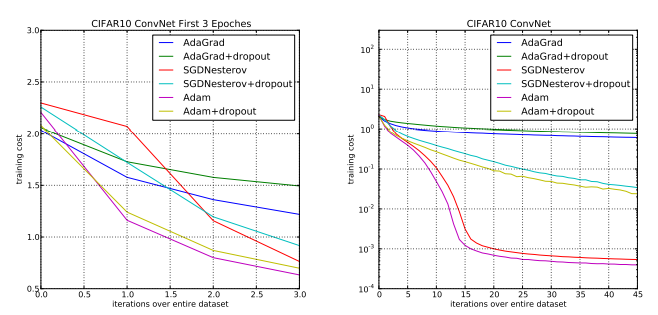

They also mentioned in the paper that the second moment estimate \\(\hat v_t\\), vanished to zero after few epochs and is dominates by \\(\epsilon\\) term.

As we understand it means that Adam preforms much larger steps.

### Our Experiment results

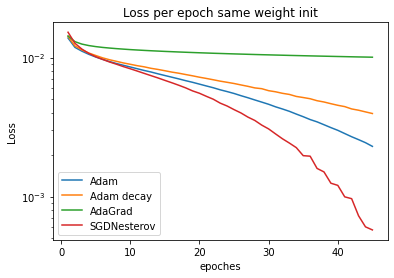

In [91]:
plt.plot(np.arange(1,epochs+1), loss_adam_same[45:], label='Adam')
plt.plot(np.arange(1,epochs+1), loss_adam_decay_same[45:], label='Adam decay')
plt.plot(np.arange(1,epochs+1), loss_adagrad_same[45:], label='AdaGrad')
plt.plot(np.arange(1,epochs+1), loss_sgdnst_same[45:], label='SGDNesterov')
plt.legend()
plt.title("Loss per epoch same weight init")
plt.yscale('log')
plt.xlabel("epoches")
plt.ylabel("Loss")
plt.show()

In [98]:
print(f'adam accuracy: {score(model_adam_same_init, testloader)}')
print(f'adam with decay accuracy: {score(model_adam_decay_same_init, testloader)}')
print(f'adagrad accuracy: {score(model_adagrad_same_init, testloader)}')
print(f'sgd nesterov accuracy: {score(model_nesterov_same_init, testloader)}')

adam accuracy: 62.46
adam with decay accuracy: 63.57
adagrad accuracy: 53.34
sgd nesterov accuracy: 62.67


 - **Our results do not match the results in the paper**. 
 - In the paper we can see that Adam yields the best results. This is not the case in our experiment (sgd Nesterov is better).
 - Also, Nesterov and Adam optimizers are similar and both converged very fast to a low loss relatively to other optimizers.
 - In our case, only Nesterov has this gap relatively to the others, but still it does not converge.
 - We can see that both in the paper and in our case, Adagrad did not succeed to learn. An explanation for that might be that the sum of square gradients was very large. Thus, the step size was very small and the parameters did not update.
 - We see that in this case the choice of learning rate decay was not efficient. Adam with constant learning rate got better, and that implies that larger steps were needed in this case.